In [1]:
import sklearn
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
from util import evaluate_data, graph_LC, graph_C, normalize_data, create_stratified_data, prepare_data, preprocess_ufc_data

MLPClassifier()
              precision    recall  f1-score   support

           1    0.93087   0.93899   0.93491      1262
           2    0.93482   0.93540   0.93511      1610
           3    0.93638   0.92642   0.93137      1128

    accuracy                        0.93400      4000
   macro avg    0.93402   0.93360   0.93380      4000
weighted avg    0.93402   0.93400   0.93399      4000

[0.92998109 0.93495716 0.92755126 0.94743932 0.91996622 0.93994971
 0.91732863 0.90482764 0.9099254  0.93744772] 0.9269374141849059


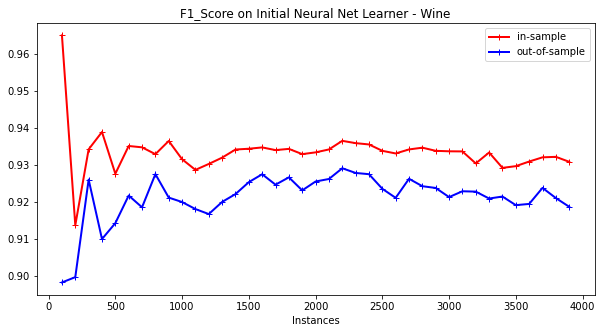

MLPClassifier(learning_rate='invscaling') 0.92968557521102
MLPClassifier(learning_rate='invscaling') 0.92968557521102


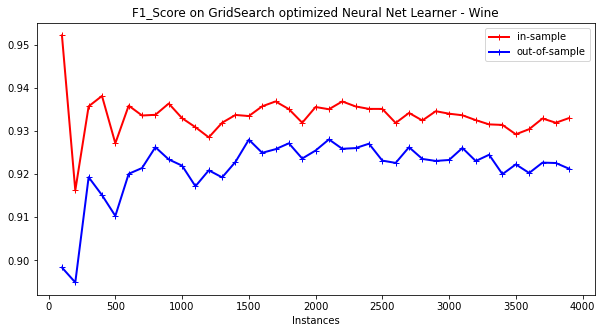

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/sbhadra/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.2min finished


[0.92252488 0.9334453  0.93800256 0.94055292 0.94183551 0.94327817
 0.94577963 0.94570283 0.94725573 0.94805881 0.94864602 0.94936935
 0.95061585 0.9502421  0.95031304 0.950735   0.95278453 0.95320373
 0.95164026 0.95326002] [0.91948317 0.92672699 0.92596085 0.92618924 0.92696314 0.92293415
 0.92399112 0.92795693 0.92443041 0.92419901 0.9266889  0.9259323
 0.92418525 0.9246586  0.92416378 0.92720302 0.92994949 0.92591601
 0.92493489 0.92397762]


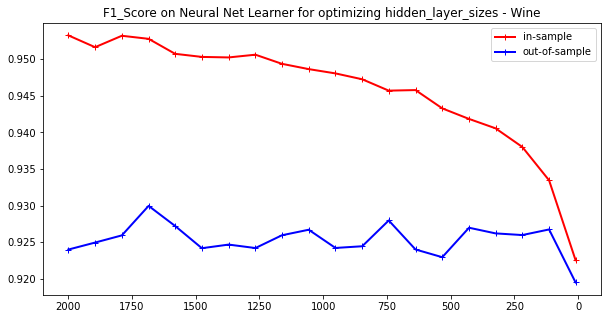

1685


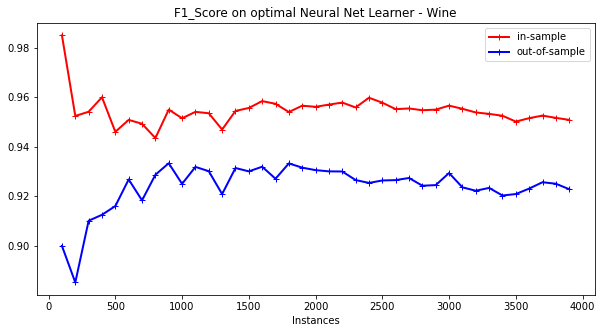

              precision    recall  f1-score   support

           1    0.92236   0.94286   0.93250       315
           2    0.94192   0.92556   0.93367       403
           3    0.92908   0.92908   0.92908       282

    accuracy                        0.93200      1000
   macro avg    0.93112   0.93250   0.93175      1000
weighted avg    0.93214   0.93200   0.93200      1000



NameError: name 'ufc_dataset' is not defined

In [4]:
def define_neural_network(input_train_set, output_train_set):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    NN_Learner = MLPClassifier()
    NN_Learner.fit(input_train_set, output_train_set.values.ravel())
    
    print(NN_Learner)
    return NN_Learner

def neural_network_predictions(NN_Learner, input_train_set, output_train_set):
    y_hat = NN_Learner.predict(input_train_set)
    percent_match = accuracy_score(output_train_set, y_hat)
    print(classification_report(output_train_set, y_hat, digits=5))
    return percent_match


def compute_score(input_train_set, output_train_set, NN_Learner, mean, title):
    result = evaluate_data(input_train_set, output_train_set, NN_Learner, f1_score, average=mean)
    graph_LC(result[0], result[1], result[2], title=title)
    

def run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting, parallel):
    grid_suggestion = GridSearchCV(MLPClassifier(), values, cv=cross_validation_splitter, scoring=weighting, n_jobs = parallel)
    grid_suggestion.fit(input_train_set, output_train_set.values.ravel())
    print(grid_suggestion.best_estimator_, grid_suggestion.best_score_)
    
    return grid_suggestion
    
    
def run_validation_curve(NN_Learner, input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, title):
    result_train, result_test = validation_curve(
        NN_Learner, input_train_set, output_train_set.values.ravel(), param_name=hyperparameter, 
        param_range=hyperparameter_values, scoring=weighting, verbose=1, cv=10, n_jobs=-1
    )
    print(result_train.mean(axis=1), result_test.mean(axis=1))
    graph_C(result_train.mean(axis=1), result_test.mean(axis=1), hyperparameter_values, title=title, inverse_x=True)
    
    return result_train, result_test

def wine_dataset():
    target_feature = "class"
    mean = "weighted"
    weighting = "f1_weighted"
    hyperparameter = "hidden_layer_sizes"
    cross_validation_splitter = 10
    parallel = -1

    np.random.seed(42)
    wine_dataset = pd.read_csv("wine_dataset.csv")


    target = wine_dataset[target_feature]
    wine_dataset = normalize_data(wine_dataset)
    wine_dataset[target_feature] = target

    in_sample, out_of_sample = create_stratified_data(target_feature, wine_dataset)

    output_train_set, input_train_set, output_test_set, input_test_set = prepare_data(in_sample, out_of_sample, target_feature)
    
    NN_Learner = define_neural_network(input_train_set, output_train_set)

    
    percent_match = neural_network_predictions(NN_Learner, input_train_set, output_train_set)

    result = cross_val_score(NN_Learner, input_train_set, output_train_set.values.ravel(), scoring=weighting, cv=cross_validation_splitter)
    print(result, result.mean())


    compute_score(input_train_set, output_train_set, NN_Learner, mean, "F1_Score on Initial Neural Net Learner - Wine")
    
    values = {
        "alpha" : [0.1, 0.01, 0.001, 0.0001],
        'learning_rate': ['constant', 'invscaling'], 
        'beta_1' : [0.9, 0.95, 0.99]
    }
    grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting, parallel)

    print(grid_suggestion.best_estimator_, grid_suggestion.best_score_)
    
    compute_score(input_train_set, output_train_set, NN_Learner, mean, "F1_Score on GridSearch optimized Neural Net Learner - Wine")
    
    NN_Learner = MLPClassifier()

    hyperparameter_values = np.linspace(10, 2000, 20).astype(int)
    #hyperparameter_values = [(int(x),int(y)) for x in np.linspace(start = 1, stop = 101, num = 5) for y in np.linspace(start = 1, stop = 101, num = 5)]

    result_train, result_test = run_validation_curve(NN_Learner, input_train_set, output_train_set, hyperparameter_values, weighting, hyperparameter, "F1_Score on Neural Net Learner for optimizing hidden_layer_sizes - Wine")

    j = result_test.mean(axis=1).argmax()
    optimal_layers = hyperparameter_values[j]
    print(optimal_layers)
    
    optimized_NN = MLPClassifier(hidden_layer_sizes=optimal_layers)
    
    compute_score(input_train_set, output_train_set, optimized_NN, mean, "F1_Score on optimal Neural Net Learner - Wine")

    optimized_NN.fit(input_train_set, output_train_set.values.ravel())
    test_y_hat = optimized_NN.predict(input_test_set)
    print(classification_report(output_test_set, test_y_hat, digits=5))
    
    
    def ufc_dataset():
        target_feature = "Winner"
        mean = "macro"
        weighting = "f1_macro"
        hyperparameter = "hidden_layer_sizes"
        cross_validation_splitter = 10
        parallel = -1
        

        np.random.seed(42)
        ufc_dataset = pd.read_csv("ufc_data.csv")
        ufc_dataset = preprocess_ufc_data(ufc_dataset)


        ufc_dataset = normalize_data(ufc_dataset)

        in_sample, out_of_sample = create_stratified_data(target_feature, ufc_dataset)

        output_train_set, input_train_set, output_test_set, input_test_set = prepare_data(in_sample, out_of_sample, target_feature)

        NN_Learner = define_neural_network(input_train_set, output_train_set)

        accuracy = neural_network_predictions(NN_Learner, input_train_set, output_train_set)

        result = cross_val_score(NN_Learner, input_train_set, output_train_set.values.ravel(), scoring=weighting, cv=cross_validation_splitter)
        result, result.mean()

        compute_score(input_train_set, output_train_set, NN_Learner, mean, "F1_Score on Initial Neural Net Learner - UFC")

        values = {
        'hidden_layer_sizes': [(75), (100), (60, 60)],
        'alpha': [0.01, 0.001, 0.0001], 
        'beta_1' : [0.9, 0.95, 0.99]
        }

        grid_suggestion = run_gridsearch(values, input_train_set, output_train_set, cross_validation_splitter, weighting, parallel)

        print(grid_suggestion.best_estimator_, grid_suggestion.best_score_)

        compute_score(input_train_set, output_train_set, NN_Learner, mean, "F1_Score on GridSearch optimized Neural Net Learner - UFC")

        optimized_NN = MLPClassifier(beta_1=0.95, hidden_layer_sizes=100)


        hyperparameter_values =  np.linspace(5, 100, 20).astype(int)
        params = [(x,) for x in hyperparameter_values]
        result_train, result_test = run_validation_curve(optimized_NN, input_train_set, output_train_set, params, weighting, hyperparameter, "F1_Score on Neural Net Learner for optimizing hidden_layer_sizes - UFC")

        j = result_test.mean(axis=1).argmax()
        optimal_layers = hyperparameter_values[j]
        print(optimal_layers)

        optimized_NN = MLPClassifier(beta_1=0.99, hidden_layer_sizes=30)
        compute_score(input_train_set, output_train_set, optimized_NN, mean, "F1_Score on optimal Neural Net Learner - UFC")


        optimized_NN.fit(input_train_set, output_train_set.values.ravel())
        test_y_hat = optimized_NN.predict(input_test_set)
        print(classification_report(output_test_set, test_y_hat,digits=5))
        print(confusion_matrix(output_test_set, test_y_hat))
    

if __name__ == "__main__":
    wine_dataset()
    ufc_dataset()